**Download all the needed data, models and apis**

In [1]:
try:
  import google.colab
  colab = True
except:
  colab = False
import timeit
import platform
import os
import sys

if colab is True:
    from google.colab.patches import cv2_imshow
    
# Operating System
OS = platform.system()                                                               # returns 'Windows', 'Linux', etc

start_download_time = timeit.default_timer()

if not os.path.exists("./wpodnet-dataset.zip"):
    os.system('gdown --id "1Oz_-AEfP5PPXWQ_y8RjIb80CdWejQ1fA" --output "./wpodnet-dataset.zip"')
    if OS == "Linux":
        os.system('unzip -o -n "./wpodnet-dataset.zip" -d "./"')

if not os.path.exists("./wpod-net.json"):
    os.system('gdown --id "1QJPQpMcJ3UrSFSpjJhroc7MZJrDDF4hn" --output "./wpod-net.json"')
    
if not os.path.exists("./wpod-net.h5"):
    os.system('gdown --id "1715mUMGm56IjdV2ED-eC16CU7hSf4qEZ" --output "./wpod-net.h5"')

print("Download and Unzip of Dataset and Models Time : ", timeit.default_timer() - start_download_time)

Download and Unzip of Dataset and Models Time :  85.45746946200006


# All Imports


In [2]:
import sys
import numpy as np
import cv2
import argparse
import keras
import math
import tensorflow
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, CSVLogger, ModelCheckpoint

from random import choice
from os.path import isfile, isdir, basename, splitext
from os import makedirs

from src.keras_utils import save_model, load_model
from src.label import readShapes
from src.loss import loss
from src.utils import image_files_from_folder, show
from src.sampler import augment_sample, labels2output_map
from src.data_generator import DataGenerator
import matplotlib.pyplot as plt
from pdb import set_trace as pause

**Check all the versions available on the current platform**

In [3]:
print("Python version: ", sys.version.split('(')[0])
print("Tensorflow version: ", tensorflow.__version__)
print("Keras version: ", keras.__version__)

Python version:  3.7.10 
Tensorflow version:  2.4.1
Keras version:  2.4.3


# Functions Definitions


In [4]:
def load_network(modelpath,input_dim):

	model = load_model(modelpath)
	input_shape = (input_dim,input_dim,3)

	# Fixed input size for training
	inputs  = keras.layers.Input(shape=(input_dim,input_dim,3))
	outputs = model(inputs)

	output_shape = tuple([s for s in outputs.shape[1:]])
	output_dim   = output_shape[1]
	model_stride = input_dim / output_dim

	assert input_dim % output_dim == 0, \
		'The output resolution must be divisible by the input resolution'

	assert model_stride == 2**4, \
		'Make sure your model generates a feature map with resolution ' \
		'16x smaller than the input'

	return model, model_stride, input_shape, output_shape

def process_data_item(data_item,dim,model_stride):
	XX,llp,pts = augment_sample(data_item[0],data_item[1].pts,dim)
	YY = labels2output_map(llp,pts,dim,model_stride)
	return XX,YY

# All Globals

In [5]:
model_path = "./src/wpod-net.json"
model_name = "WPOD-NET"
train_dir = "./wpodnet_dataset/"
train_with_epochs = False
remove_finally = True
iterations = 10
batch_size = 32
output_dir = "./"
optimizer = 'Adam'
lr = 0.001
test_inference = False

# Data Preparation

In [6]:
os.system("rm wpodnet_dataset/.DS_Store")

0

In [7]:
import json
import csv
import os

dirs = os.listdir(train_dir)

for dir in dirs:
  directory = train_dir+dir
  annotation_file = directory + '/metadata_coco.json'
  print(directory)
  bbox = {}
  
  with open(annotation_file) as json_file:
      coco_annotations = json.load(json_file)
      images = coco_annotations['images']
      for an in coco_annotations['annotations']:
        
        id_image = int(an['image_id'])
        image = [x for x in images if x['id'] == id_image][0] 

        #print(an['segmentation'], image['file_name'])
        for c in an['segmentation']:
          res = "4,"
          resx = ""
          resy = ""
          for i, x in enumerate(c):
            if i%2 == 0:
              resx += "{:.6f},".format(x/image["width"])
            else:
              resy += "{:.6f},".format(x/image["height"])
          res += resx+resy+"LP,\n"
          
        if bbox.get(int(an['image_id'])) is None:
          bbox[image['file_name']] = [res]
        else:
          bbox[image["file_name"]].append(res)
        

  for k in bbox.keys():
    with open(directory+"/"+k.split(".")[0]+".txt", "a") as myfile:
        myfile.write("".join(bbox[k]))




wpodnet_dataset/03-04-2021
wpodnet_dataset/11-05-2021
wpodnet_dataset/29-04-2021
wpodnet_dataset/29-03-2021
wpodnet_dataset/31-03-2021
wpodnet_dataset/01-04-2021
wpodnet_dataset/02-04-2021
wpodnet_dataset/11-04-2021
wpodnet_dataset/30-03-2021
wpodnet_dataset/05-04-2021


# Model Loading

In [8]:
import os

netname = basename(model_name)
# comment next line to train on all dataset
dirs = ['31-03-2021', '30-04-2021']
outdir = './output/'
iterations = iterations
batch_size = 32
dim 		= 208

if not isdir(outdir):
  makedirs(outdir)

model,model_stride,xshape,yshape = load_network(model_path,dim)
print('Checking input directory...')

Files = []
for dir in dirs:
  Files += image_files_from_folder(train_dir+dir)

Data = []
for file in Files:
  labfile = splitext(file)[0] + '.txt'
  if isfile(labfile):
    L = readShapes(labfile)
    I = cv2.imread(file)
    Data.append([I,L[0]])

print('%d images with labels found' % len(Data))

Xtrain = np.empty((batch_size,dim,dim,3),dtype='single')
Ytrain = np.empty((batch_size, int(dim/model_stride),int(dim/model_stride),2*4+1))

model_path_backup = '%s/%s_backup' % (outdir,netname)
model_path_final  = '%s/%s_final'  % (outdir,netname)



Checking input directory...
76 images with labels found


# Model Preparation: loading, compiling, etc. 

In [9]:
print("Compiling Model...")
opt = getattr(keras.optimizers, optimizer)(lr=lr)
model.compile(loss=loss, optimizer=opt)
print(model.summary())
#print(model.input_shape)
#print(Ytrain)

Compiling Model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 448         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
_________________________________________________________________________

# Preprocessing: data augmentation, etc.

In [10]:
dg = DataGenerator(	data=Data, \
          process_data_item_func=lambda x: process_data_item(x, dim, int(model_stride)),\
          xshape=xshape, \
          yshape=(yshape[0],yshape[1],yshape[2]+1), \
          nthreads=2, \
          pool_size=1000, \
          min_nsamples=100 )
dg.start()

# Test Data Augmentation


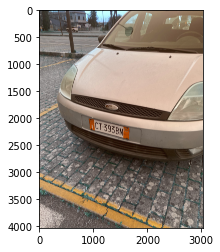

208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.30707648 0.77010949 0.72370863 0.26385403]
 [0.33712282 0.33641437 0.47099182 0.48144133]]


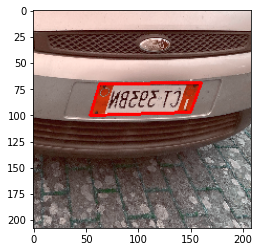

In [11]:


test = Data[0]
plt.imshow(test[0])
plt.show()
print(dim)
XX,llp,pts = augment_sample(test[0],test[1].pts,dim)
print(pts)
c = pts

pts = np.array([[c[0][0]*dim, c[1][0]*dim],
                [c[0][1]*dim, c[1][1]*dim],
                [c[0][2]*dim, c[1][2]*dim],
                [c[0][3]*dim, c[1][3]*dim]], np.int32)

pts = pts.reshape((-1, 1, 2))
image = cv2.polylines(XX, [pts], True, (255, 0, 0), 2)

plt.imshow(XX)
plt.show()


# Train model

In [12]:
if train_with_epochs == False: 
  min_loss = None
  for it in range(iterations):

    print('Iter. %d (of %d)' % (it+1,iterations))

    Xtrain,Ytrain = dg.get_batch(batch_size)
    train_loss = model.train_on_batch(Xtrain,Ytrain) 

    # Save model every time the loss get lower
    if min_loss is None:
      min_loss = train_loss
    else:
      if train_loss<min_loss:
        print('Saving model (%s)' % model_path_backup)
        save_model(model,model_path_backup)
        min_loss=train_loss

    print('\tLoss: {} \tBest Loss: {}'.format(train_loss, min_loss))

Iter. 1 (of 10)
	Loss: 3.9731998443603516 	Best Loss: 3.9731998443603516
Iter. 2 (of 10)
	Loss: 7.895474910736084 	Best Loss: 3.9731998443603516
Iter. 3 (of 10)
Saving model (./output//WPOD-NET_backup)
	Loss: 2.7852542400360107 	Best Loss: 2.7852542400360107
Iter. 4 (of 10)
	Loss: 3.5758094787597656 	Best Loss: 2.7852542400360107
Iter. 5 (of 10)
	Loss: 4.407123565673828 	Best Loss: 2.7852542400360107
Iter. 6 (of 10)
	Loss: 4.094677925109863 	Best Loss: 2.7852542400360107
Iter. 7 (of 10)
	Loss: 3.152290105819702 	Best Loss: 2.7852542400360107
Iter. 8 (of 10)
Saving model (./output//WPOD-NET_backup)
	Loss: 2.5006184577941895 	Best Loss: 2.5006184577941895
Iter. 9 (of 10)
	Loss: 4.817917346954346 	Best Loss: 2.5006184577941895
Iter. 10 (of 10)
	Loss: 2.5824313163757324 	Best Loss: 2.5006184577941895


# Model Training Mode 2

# Saving last epoch model 

In [15]:
print('Stopping data generator')
dg.stop()

print('Saving model (%s)' % model_path_final)
save_model(model,model_path_final)

Stopping data generator
Saving model (./output//WPOD-NET_final)


In [16]:
if OS == "Linux" and remove_finally == True:
  os.system('rm "./wpodnet-dataset.zip"')
  os.system('rm -rf "./wpodnet_dataset"')